In [1]:
# Basic Imports
import pathlib
from pathlib import Path
import os
import sys
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union
import json
import time
from tqdm.auto import tqdm
import numpy as np
from copy import copy
from glob import glob
from collections import defaultdict
import matplotlib.pyplot as plt

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# JAX/Flax
import jax
import jax.numpy as jnp
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state, checkpoints
import optax

# For ODESolver
from scipy import integrate

# PyTorch for Dataloaders
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.datasets import MNIST


# Path to import created files
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/src")

# Import created functions
# from data import make_dataset as mkds
# from visualization import visualize as vis
# from models import train_model as tm
# from models import sampling as smp

In [7]:
def custom_transform(x):
    # A couple of modifications here compared to tutorial #3 since we're using a CNN
    # Input: (28, 28) uint8 [0, 255] torch.Tensor, Output: (28, 28, 1) float32 [0, 1] np array
    return np.expand_dims(np.array(x, dtype=np.float32), axis=2) / 255.

def custom_collate_fn(batch):
    """Provides us with batches of numpy arrays and not PyTorch's tensors."""
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

mnist_img_size = (28, 28, 1)
batch_size = 128

train_dataset = MNIST(root='saved_data/train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='saved_data/test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data)
train_lbls = jnp.array(train_dataset.targets)

# np.expand_dims is to convert shape from (10000, 28, 28) -> (10000, 28, 28, 1)
# We don't have to do this for training images because custom_transform does it for us.
test_images = np.expand_dims(jnp.array(test_dataset.data), axis=3)
test_lbls = jnp.array(test_dataset.targets)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting saved_data/train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to saved_data/train_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting saved_data/train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to saved_data/train_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting saved_data/train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to saved_data/train_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting saved_data/train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to saved_data/train_mnist/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting saved_data/test_mnist/MNIST/raw/train-images-idx3-ubyte.gz to saved_data/test_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting saved_data/test_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to saved_data/test_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting saved_data/test_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to saved_data/test_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting saved_data/test_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to saved_data/test_mnist/MNIST/raw



In [5]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [6]:
test_dataset.data.shape

torch.Size([10000, 28, 28])

7


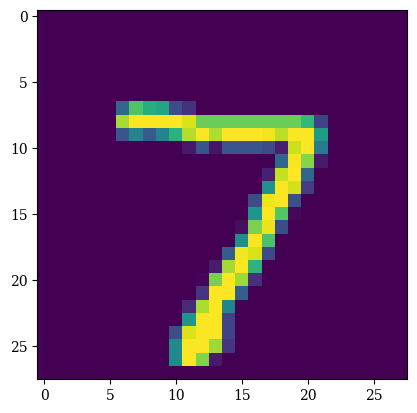

In [3]:
# Visualize a single image
imgs, lbls = next(iter(test_loader))
img = imgs[0].reshape(mnist_img_size)[:, :, 0]
gt_lbl = lbls[0]

print(gt_lbl)
plt.imshow(img); plt.show()